In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('coded.csv')
#df = df.dropna()
#df = pd.read_csv('flying-etiquette.csv')

In [2]:
from features_trans_back import features_trans_back_shortened as features_trans_back
for column in df.columns:
    try:
        features_trans_back(column)
    except:
        print(column, 'failed')

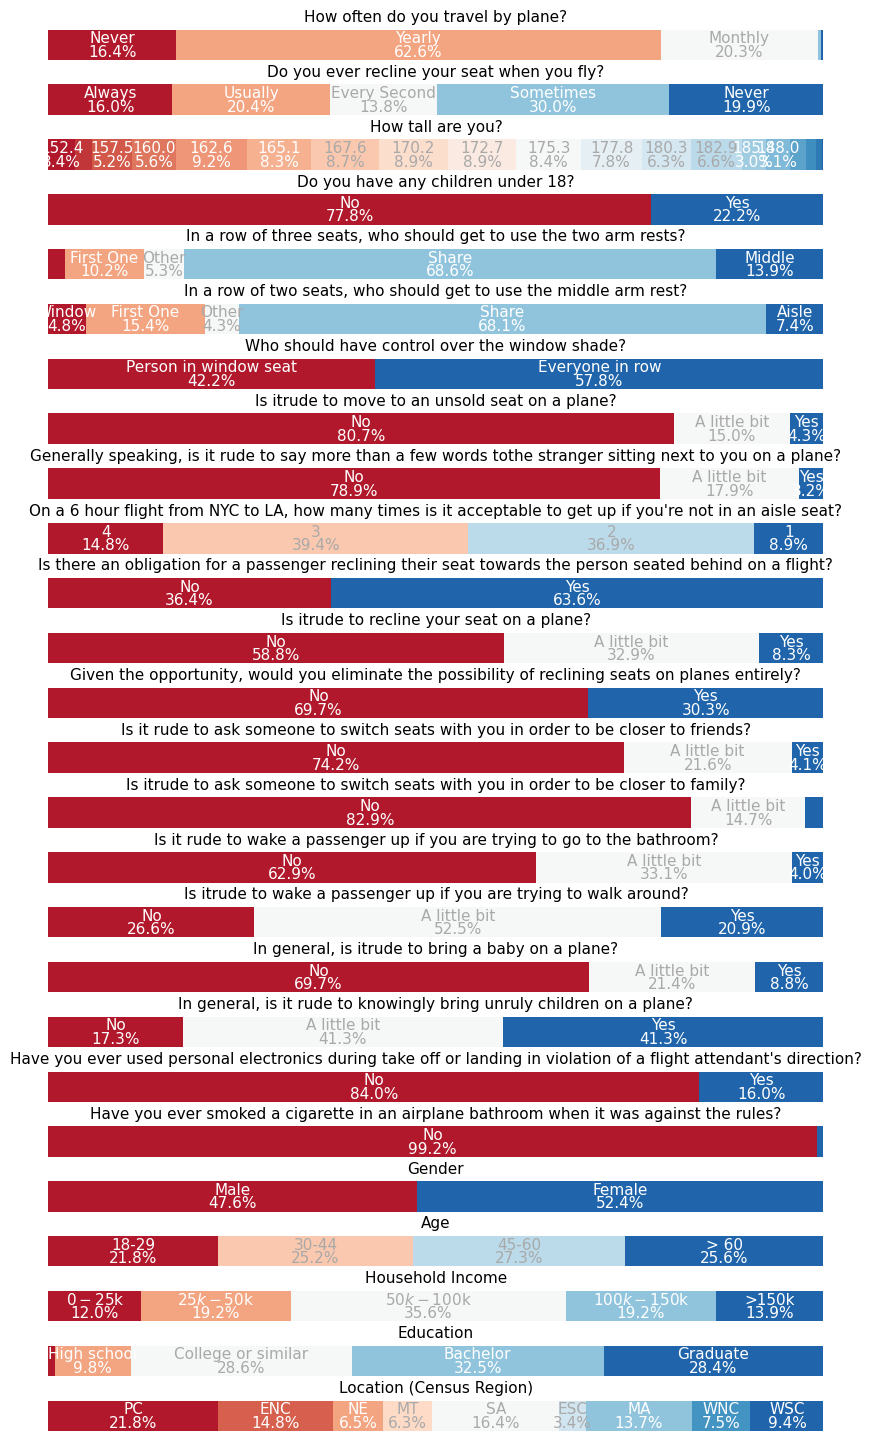

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def question_map(question):
    if question == 'Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?':
        return 'Is there an obligation for a passenger reclining their seat towards the person seated behind on a flight?'
    elif question == 'Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?':
        return "Have you ever used personal electronics during takeoff or landing against a flight attendant's instructions?"
    else:
        return question


def adapted_survey(axes, question, answers, category_names, index, percentage_threshold=3, text_size=11):
    """
    Adapted survey function to handle variable number of answers per question and plot on a given axis.

    Parameters:
    - axes: matplotlib.axes.Axes
        The axes array to plot the graph.
    - question: str
        The question label.
    - answers: pandas.Series
        A series of answers for the question.
    - category_names: list of str
        The category labels for this specific question.
    - index: int
        The index of the current question.
    - percentage_threshold: float, optional (default=3)
        The threshold below which percentage values will not be displayed.
    - text_size: int, optional (default=12)
        The font size for the text in the plot.
    """
    # Count the frequency of each answer and ensure the order is numerical
    answer_counts = answers.value_counts().reindex(category_names, fill_value=0).sort_index()
    total_answers = answer_counts.sum()

    # Prepare data for plotting
    data = np.array(answer_counts)
    data_cum = data.cumsum()
    
    # Get a color map with a color for NaN values
    category_colors = plt.get_cmap('RdBu')(np.linspace(0.1, 0.9, len(category_names) -1))  # Add 1 for NaN

    ax = axes[index] if len(axes) > 1 else axes
    ax.invert_xaxis()
    ax.set_ylim(-0.18, 0.18)  # Makes bars thinner
    ax.yaxis.set_visible(False)
    ax.set_xlim(0, np.max(data_cum))
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    # Hide the spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set and adjust the position of the title
    ax.set_title(question_map(question), loc='center', fontsize=text_size)  # Adjust title font size
    ax.title.set_position([.5, 1.02])  # Further adjust title position

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        # Filter out NaN values for the current category
        filtered_answers = answers[answers.notna()]
        
        width = filtered_answers[filtered_answers == colname].count()
        start = data_cum[i] - width
        ax.barh([question], width, left=start, height=0.5, label=colname, color=color)

        # Calculate and format the percentage
        percentage = (width / total_answers) * 100

        # Display percentage values only if they are above the threshold
        if percentage >= percentage_threshold:
            text_percentage = f'{percentage:.1f}%'  # Format the percentage
            try:
                text_answer = features_trans_back(question).get(colname, colname)  # Get the text from the dictionary
            except:
                text_answer = colname  # Answer text
            #text_answer = colname 
        else:
            text_percentage = ''  # Hide the percentage text
            text_answer = ''  # Hide the answer text

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'

        # Position the text inside the bar with reduced gap
        text_x = start + width / 2
        text_y_percentage = -0.08  # Adjust this value to control the gap between percentage and bar
        text_y_answer = 0.08  # Adjust this value to control the gap between answer and bar
        ax.text(text_x, text_y_percentage, text_percentage, ha='center', va='center', color=text_color, fontsize=text_size)  # Adjust font size
        
        # Only display answer text if percentage text is displayed
        if text_percentage:
            ax.text(text_x, text_y_answer, text_answer, ha='center', va='center', color=text_color, fontsize=text_size)  # Adjust font size

# Usage with your DataFrame
question_columns = [column for column in df.columns if column not in ['RespondentID']]
total_questions = len(question_columns)

# Adjust the height of each subplot here
subplot_height = 0.7  # Decrease this value to reduce vertical spacing
fig, axes = plt.subplots(total_questions, 1, figsize=(10, total_questions * subplot_height), squeeze=False)
axes = axes.flatten()

for index, column in enumerate(question_columns):
    unique_answers = np.sort(df[column].unique())
    adapted_survey(axes, column, df[column], unique_answers, index, percentage_threshold=3, text_size=11)  # Adjust text size as needed

# Remove horizontal padding between subplots
plt.subplots_adjust(wspace=0)  # Set wspace to 0 to remove horizontal spacing between subplots
plt.subplots_adjust(hspace=0.8)
plt.show()


In [114]:
from scipy.stats import pearsonr
import numpy as np
rho = df.dropna().corr()

# Calculate p-values
pval = df.dropna().corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))

# Combine correlation values with asterisk markings
rho_with_asterisks = rho.round(2).astype(str) + p

# Define a function to determine background color intensity based on the number of asterisks
def background_color(cell):
    num_asterisks = cell.count('*')
    if num_asterisks == 0:
        return ''
    elif num_asterisks == 1:
        return 'background-color: yellow'
    elif num_asterisks == 2:
        return 'background-color: orange'
    else:
        return 'background-color: red'

# Apply background color intensity based on the number of asterisks
rho_with_asterisks = rho_with_asterisks.style.applymap(background_color)

# Display the styled correlation matrix
rho_with_asterisks

,RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Age,Household Income,Education,Location (Census Region)
RespondentID,1.0***,-0.03,-0.01,0.16***,-0.0,-0.0,0.05,-0.05,0.01,-0.01,0.13**,0.04,-0.07,-0.05,0.09*,0.05,-0.03,0.02,0.04,0.06,-0.04,-0.02,-0.21***,0.05,-0.03,-0.03,-0.03
How often do you travel by plane?,-0.03,1.0***,0.03,0.06,-0.03,0.06,0.06,-0.04,0.06,0.02,0.01,-0.06,0.12**,0.05,-0.02,0.02,0.01,-0.04,0.05,0.04,0.18***,0.13**,-0.08,-0.07,0.2***,0.1*,-0.0
Do you ever recline your seat when you fly?,-0.01,0.03,1.0***,0.0,-0.04,0.06,-0.04,0.02,0.04,0.07,0.08*,0.39***,0.51***,0.38***,-0.04,-0.02,-0.01,0.03,-0.04,-0.0,-0.12**,-0.05,0.03,-0.06,-0.02,0.01,0.04
How tall are you?,0.16***,0.06,0.0,1.0***,0.05,0.04,0.05,-0.03,-0.0,-0.01,-0.08,0.02,0.04,0.07,-0.01,-0.02,-0.11**,-0.07,0.07,0.11**,0.03,0.02,-0.68***,-0.0,0.05,0.02,-0.04
Do you have any children under 18?,-0.0,-0.03,-0.04,0.05,1.0***,-0.05,-0.06,0.02,-0.04,-0.08,-0.0,-0.03,-0.08*,-0.07,-0.01,-0.03,-0.02,0.0,-0.17***,-0.22***,-0.03,0.01,-0.04,-0.09*,0.06,-0.04,0.01
"In a row of three seats, who should get to use the two arm rests?",-0.0,0.06,0.06,0.04,-0.05,1.0***,0.34***,0.1*,0.1*,0.02,0.01,0.07,-0.05,0.04,-0.01,-0.05,-0.06,0.01,-0.12**,-0.01,-0.03,-0.04,-0.02,0.08,0.01,-0.06,-0.0
"In a row of two seats, who should get to use the middle arm rest?",0.05,0.06,-0.04,0.05,-0.06,0.34***,1.0***,0.05,0.02,-0.01,0.03,0.04,-0.0,-0.02,0.01,-0.01,0.02,0.06,-0.05,-0.01,0.05,0.05,-0.02,0.02,-0.02,-0.01,0.06
Who should have control over the window shade?,-0.05,-0.04,0.02,-0.03,0.02,0.1*,0.05,1.0***,-0.01,-0.08*,-0.06,0.09*,-0.04,-0.02,-0.09*,-0.13**,-0.01,-0.07,-0.09*,-0.08,-0.03,-0.05,0.04,0.02,0.08*,0.05,0.02
Is itrude to move to an unsold seat on a plane?,0.01,0.06,0.04,-0.0,-0.04,0.1*,0.02,-0.01,1.0***,0.22***,0.06,0.03,0.04,0.06,0.18***,0.15***,0.02,0.1*,0.08,0.07,-0.04,0.09*,-0.03,-0.03,-0.1*,-0.11**,0.05
"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?",-0.01,0.02,0.07,-0.01,-0.08,0.02,-0.01,-0.08*,0.22***,1.0***,0.12**,0.05,0.14***,0.1*,0.05,0.07,0.1*,0.11**,0.21***,0.11**,0.02,0.04,0.04,0.0,-0.01,0.04,0.05


In [100]:
from scipy.stats import pearsonr
def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(df).style.background_gradient(cmap='coolwarm')

,RespondentID,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,"In a row of three seats, who should get to use the two arm rests?","In a row of two seats, who should get to use the middle arm rest?",Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,"Given the opportunity, would you eliminate the possibility of reclining seats on planes entirely?",Is it rude to ask someone to switch seats with you in order to be closer to friends?,Is itrude to ask someone to switch seats with you in order to be closer to family?,Is it rude to wake a passenger up if you are trying to go to the bathroom?,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Age,Household Income,Education,Location (Census Region)
RespondentID,0.000000,0.492200,0.643100,0.000000,0.507600,0.947200,0.013000,0.050600,0.549800,0.252700,0.004000,0.241200,0.162700,0.622400,0.002700,0.187400,0.200300,0.359700,0.649300,0.911300,0.408300,0.874800,0.000000,0.617200,0.052100,0.792300,0.321700
How often do you travel by plane?,0.492200,0.000000,0.788900,0.003400,0.502500,0.879900,0.204500,0.512000,0.097800,0.221200,0.810600,0.105500,0.002500,0.093100,0.586000,0.107800,0.133300,0.248000,0.142200,0.727500,0.000000,0.000000,0.223400,0.703800,0.000000,0.000000,0.675400
Do you ever recline your seat when you fly?,0.643100,0.788900,0.000000,0.738800,0.174000,0.270200,0.743700,0.554100,0.047800,0.077500,0.027700,0.000000,0.000000,0.000000,0.262400,0.330900,0.825000,0.117800,0.935700,0.947800,0.000400,0.088200,0.649600,0.060600,0.636800,0.725200,0.466000
How tall are you?,0.000000,0.003400,0.738800,0.000000,0.294000,0.883300,0.267000,0.236200,0.719700,0.964500,0.106500,0.790400,0.212800,0.017300,0.227600,0.324900,0.002300,0.185800,0.008200,0.031000,0.019200,0.016600,0.000000,0.778400,0.070700,0.167800,0.249500
Do you have any children under 18?,0.507600,0.502500,0.174000,0.294000,0.000000,0.541400,0.323100,0.637600,0.492600,0.117800,0.906200,0.479400,0.031300,0.047000,0.905400,0.438800,0.896700,0.946700,0.000000,0.000000,0.237100,0.188500,0.499700,0.025500,0.021700,0.506100,0.721900
"In a row of three seats, who should get to use the two arm rests?",0.947200,0.879900,0.270200,0.883300,0.541400,0.000000,0.000000,0.005200,0.288900,0.949400,0.595400,0.008800,0.383100,0.428200,0.183600,0.047600,0.001300,0.551300,0.021700,0.845500,0.120900,0.010900,0.992200,0.001600,0.476200,0.719400,0.731400
"In a row of two seats, who should get to use the middle arm rest?",0.013000,0.204500,0.743700,0.267000,0.323100,0.000000,0.000000,0.045200,0.566800,0.871600,0.471500,0.002800,0.532400,0.675700,0.968400,0.448400,0.471200,0.368000,0.527000,0.720100,0.848500,0.684000,0.241400,0.656800,0.477300,0.821200,0.378700
Who should have control over the window shade?,0.050600,0.512000,0.554100,0.236200,0.637600,0.005200,0.045200,0.000000,0.507800,0.218000,0.033100,0.001000,0.409700,0.565300,0.016600,0.001300,0.729100,0.221200,0.032600,0.139600,0.023200,0.112500,0.395600,0.069600,0.384500,0.128800,0.833600
Is itrude to move to an unsold seat on a plane?,0.549800,0.097800,0.047800,0.719700,0.492600,0.288900,0.566800,0.507800,0.000000,0.000000,0.051500,0.32

      How often do you travel by plane?  \
2                                   4.0   
3                                   4.0   
4                                   3.0   
5                                   4.0   
6                                   3.0   
...                                 ...   
1027                                4.0   
1028                                4.0   
1032                                4.0   
1035                                4.0   
1039                                4.0   

      Do you ever recline your seat when you fly?  How tall are you?  \
2                                             1.0             172.72   
3                                             0.0             180.34   
4                                             2.0             170.18   
5                                             1.0             175.26   
6                                             3.0             187.96   
...                                           ...  

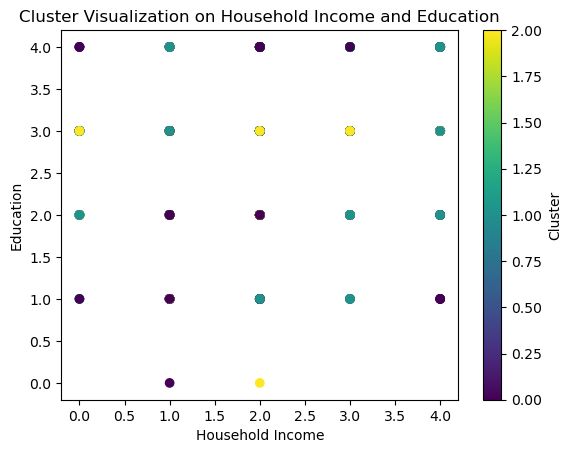

In [11]:
from sklearn.cluster import KMeans

# Filter the dataframe to include only rows with float values
filtered_df = df.select_dtypes(include=['float'])

# Drop rows with NaN values
filtered_df = filtered_df.dropna()


# Create an instance of KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=3)

# Fit the data to the KMeans model
kmeans.fit(filtered_df)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
filtered_df['Cluster'] = cluster_labels

# Print the updated dataframe
print(filtered_df)
df = filtered_df

plt.scatter(df['Household Income'], df['Education'], c=df['Cluster'])
plt.xlabel('Household Income')
plt.ylabel('Education')
plt.title('Cluster Visualization on Household Income and Education')
plt.colorbar(label='Cluster')
plt.show()


In [12]:
df.head()

,How often do you travel by plane?,Do you ever recline your seat when you fly?,How tall are you?,Do you have any children under 18?,Who should have control over the window shade?,Is itrude to move to an unsold seat on a plane?,"Generally speaking, is it rude to say more than a few words tothe stranger sitting next to you on a plane?","On a 6 hour flight from NYC to LA, how many times is it acceptable to get up if you're not in an aisle seat?","Under normal circumstances, does a person who reclines their seat during a flight have any obligation to the person sitting behind them?",Is itrude to recline your seat on a plane?,...,Is itrude to wake a passenger up if you are trying to walk around?,"In general, is itrude to bring a baby on a plane?","In general, is it rude to knowingly bring unruly children on a plane?",Have you ever used personal electronics during take off or landing in violation of a flight attendant's direction?,Have you ever smoked a cigarette in an airplane bathroom when it was against the rules?,Gender,Household Income,Education,Location (Census Region),Cluster
2,4.0,1.0,172.72,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,3.0,3.0,0.0,1
3,4.0,0.0,180.34,0.0,1.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,2
4,3.0,2.0,170.18,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,1.0,1.0,2.0,1.0,0.0,0.0,2.0,3.0,0.0,1
5,4.0,1.0,175.26,1.0,0.0,1.0,0.0,4.0,1.0,0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,1.0,4.0,1.0,1
6,3.0,3.0,187.96,1.0,1.0,0.0,1.0,3.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,2


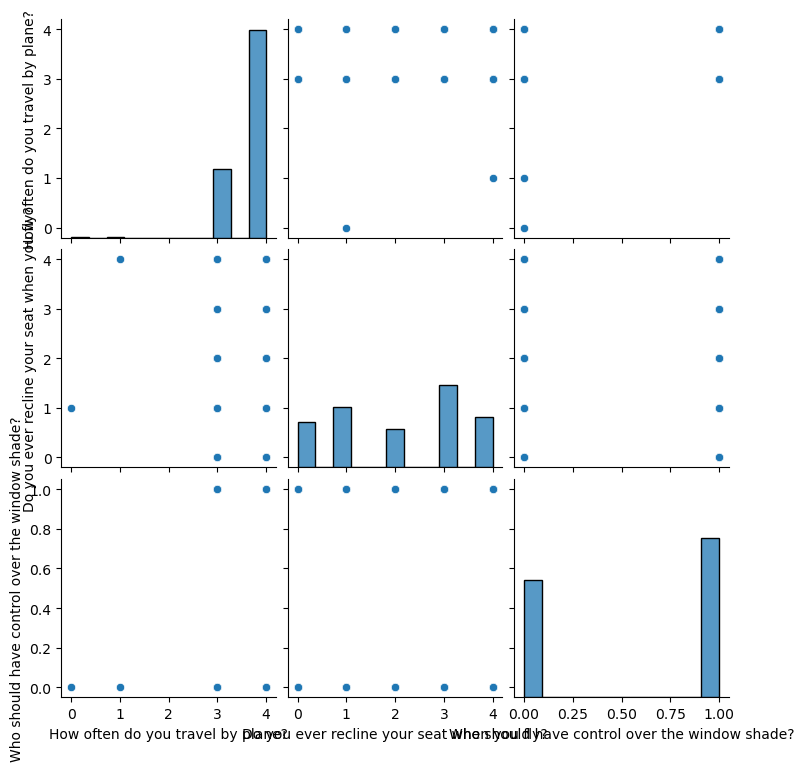

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Selecting relevant columns
selected_columns = ['How often do you travel by plane?', 'Do you ever recline your seat when you fly?',  
                    'Who should have control over the window shade?']

# Creating a subset DataFrame with selected columns
subset_df = df[selected_columns]

# Create a pair plot
sns.pairplot(subset_df)
plt.show()


In [16]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Select two categorical variables
var1 = 'Do you ever recline your seat when you fly?'
var2 = 'Who should have control over the window shade?'

# Create contingency table
contingency_table = pd.crosstab(df[var1], df[var2])

# Output the table
print(contingency_table)


Who should have control over the window shade?  0.0  1.0
Do you ever recline your seat when you fly?             
0.0                                              47   49
1.0                                              51   78
2.0                                              35   46
3.0                                              68  108
4.0                                              49   58


In [19]:
import pandas as pd
from scipy.stats import chi2_contingency
df = pd.read_csv('coded.csv')

# Create a contingency table
contingency_table = pd.crosstab(df['Household Income'], df['How often do you travel by plane?'])

print(contingency_table)
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")


How often do you travel by plane?  0.0  1.0  3.0  4.0  5.0
Household Income                                          
0.0                                  1    0    5   55   37
1.0                                  1    0   18  105   34
2.0                                  0    1   62  191   36
3.0                                  0    0   36  103   12
4.0                                  0    1   41   52    9
Chi-Square Statistic: 94.13931938665753
P-value: 4.2933924080440987e-13
